### Music vs Speech Classification with 1D-CNN End-to-end PyTorch pipeline to classify audio signals. Includes custom Dataset implementation and hyperparameter optimization

## Basic Model Design and Training

In [1]:
skip_training = False   # You can set it to True if you want to run inference on your trained model.

Import all necessary libraries.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchaudio
import glob
import os
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import copy

import warnings
warnings.filterwarnings("ignore")

# Set random seeds for all libraries
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Select the device

In [3]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Add the data path

In [ ]:
path = "dataset_speech_classification" # you can change the path if you want to store the dataset somewhere else.

The cell below defines a function for preparing a list of audio file paths from specified directories. It reads .wav files for each class (music and speech), shuffles the data, and splits it into training and validation sets based on the given validation split ratio.

In [ ]:
class DataGenerator(Dataset):
    def __init__(self, mode):
        super(DataGenerator, self).__init__()
        self.dataset_path = path

        self.duration_per_file_in_s = 5 # crop the input audios to 5 seconds
        self.sampling_rate=22050
        self.samples_per_file = int(self.duration_per_file_in_s * self.sampling_rate)

        self.music_files = glob.glob(os.path.join(path, 'music_wav', '*.wav'))
        self.speech_files = glob.glob(os.path.join(path, 'speech_wav', '*.wav'))

        # Splitting files for train and test
        music_split_idx = int(0.7 * len(self.music_files))
        speech_split_idx = int(0.7 * len(self.speech_files))

        if mode == 'train':
            self.music_files = self.music_files[:music_split_idx]
            self.speech_files = self.speech_files[:speech_split_idx]
        elif mode == 'test':
            self.music_files = self.music_files[music_split_idx:]
            self.speech_files = self.speech_files[speech_split_idx:]

        # Combine all files for indexing
        self.files = self.music_files + self.speech_files
        self.labels = [0]*len(self.music_files) + [1]*len(self.speech_files)

    def __getitem__(self, item):

        file_path = self.files[item]
        label = self.labels[item]

        audio_data, sr = torchaudio.load(file_path)

        # Resample if the sample rate is not 22050
        if sr !=  self.sampling_rate:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq= self.sampling_rate)
            audio_data = resample_transform(audio_data)

        if audio_data.size(0) > 1:  # Check if more than 1 channel
            audio_data = torch.mean(audio_data, dim=0, keepdim=True)

        if audio_data.size(1) > self.samples_per_file:
            audio_data = audio_data[:, :self.samples_per_file]  # Truncate
        else:
            pad_length = self.samples_per_file - audio_data.size(1)
            audio_data = torch.nn.functional.pad(audio_data, (0, pad_length))  # Pad at the end


        return audio_data, label

    def __len__(self):
        return len(self.files)

### Model Architecture


```python
base_config = {
    'nb_basic_blocks': int,
    'conv_channels': list,
    'kernel_size': int,
    'stride': int,
    'non_linearity': str,
    'use_batchnorm': bool,
    'use_dropout': bool,
    'batch_size': int,
    'shuffle': bool,
    'optimizer_type': str,
    'learning_rate': float,
    'apply_pooling': bool
}
```

useful links:
* https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html
* https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, non_linearity, apply_batchnorm, apply_dropout):
        super().__init__()

        self.apply_batchnorm = apply_batchnorm
        self.apply_dropout= apply_dropout

        self.conv_layer = nn.Conv1d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size, stride=stride)

        if apply_batchnorm:
            self.bn = nn.BatchNorm1d(out_channels)

        if non_linearity == "ReLU":
            self.activation_fn = nn.ReLU()
        elif non_linearity == "Tanh":
            self.activation_fn = nn.Tanh()

        if apply_dropout:
            self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv_layer(x)
        if self.apply_batchnorm:
            x = self.bn(x)
        x = self.activation_fn(x)

        if self.apply_dropout:
            x=self.dropout(x)
        return x


class MyModel(nn.Module):
    def __init__(self, nb_basic_blocks, conv_channels, kernel_size, stride, non_linearity, apply_batchnorm, apply_dropout, apply_pooling):
        super().__init__()
        self.apply_pooling = apply_pooling
        self.feature_extractor = None

        self.layers = nn.ModuleList()

        for i in range(nb_basic_blocks):
          if (i==0) :
            block=BasicBlock( 1, conv_channels[i], kernel_size, stride, non_linearity, apply_batchnorm, apply_dropout)
          else :
            block=BasicBlock( conv_channels[i-1], conv_channels[i], kernel_size, stride, non_linearity, apply_batchnorm, apply_dropout)
          self.layers.append(block)
          if (apply_pooling) and (i<nb_basic_blocks-1) :
            self.layers.append(nn.MaxPool1d(kernel_size, stride))

        self.feature_extractor = nn.Sequential(*self.layers)
        self.feature_extractor.append(nn.AdaptiveAvgPool1d(1))
        self.feature_extractor.append(nn.Flatten())
        if apply_pooling:
          self.feature_extractor.append(nn.Linear(conv_channels[-1],1))
        self.feature_extractor.append(nn.Sigmoid())


    def forward(self, x):
        x=self.feature_extractor(x)

        return x

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params

### Define Loss Function and Optimizer



In [ ]:
def loss_and_optimizer(model, optimizer_type, learning_rate):
    loss=nn.BCELoss()
    if optimizer_type=="Adam":
      optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    if optimizer_type=="SGD":
      optimizer=optim.SGD(model.parameters(),lr=learning_rate)
    return loss,optimizer

### Train and Validate Base Model

In [ ]:
base_config = {
    'nb_basic_blocks': 3,
    'conv_channels': None,
    'kernel_size': 11,
    'stride': 5,
    'non_linearity': 'Tanh',
    'use_batchnorm': False,
    'use_dropout': False,
    'batch_size': 2,
    'shuffle': False,
    'optimizer_type': None,
    'learning_rate': None,
    'apply_pooling': False
}
base_config["conv_channels"]=[32,32,1]
base_config['optimizer_type']="Adam"
base_config["learning_rate"]=.0001

### Training and Validation Loops

In [ ]:
def training_loop(nb_epochs, model, optimizer, loss_fn, train_dataloader, test_dataloader, verbose=True):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, nb_epochs + 1):
        start = time.time()
        train_loss, correct_predictions = 0., 0.
        num_samples = 0
        for i, (input_batch, target_batch) in enumerate(train_dataloader):
            input_batch=input_batch.to(device)
            target_batch = target_batch.float().unsqueeze(1).to(device)
            predictions=model(input_batch)
            loss_train=loss_fn(predictions,target_batch)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()


            # accumulate correct prediction
            correct_predictions += ((predictions.detach() >= 0.5).int() == target_batch.int()).sum().item() # number of correct predictions
            train_loss += loss_train.item()

        average_train_loss = train_loss/(i+1)
        average_train_accuracy = correct_predictions/len(train_dataloader.dataset)

        test_loss, test_accuracy = testing_loop(model, loss_fn, test_dataloader)

        train_losses.append(average_train_loss)
        val_losses.append(test_loss)
        train_accuracies.append(average_train_accuracy)
        val_accuracies.append(test_accuracy)

        end = time.time()
        epoch_time = round(end - start, 2)
        if verbose:
            print(f'Epoch {epoch}, train_loss {average_train_loss:.2f}, train_accuracy: {average_train_accuracy:.4f},',
                  f'test_loss {test_loss:.2f}, test_accuracy: {test_accuracy:.4f}, time = {epoch_time}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
def testing_loop(model, loss_fn, test_dataloader):
    model.eval()
    with torch.no_grad():
        total_loss, correct_predictions = 0., 0.
        for i, (input_batch, target_batch) in enumerate(test_dataloader):
            
            input_batch=input_batch.to(device)
            target_batch = target_batch.float().unsqueeze(1).to(device)
            predictions=model(input_batch)
            loss_test=loss_fn(predictions,target_batch)
            total_loss=total_loss+loss_test.item()
            correct_predictions += ((predictions.detach() >= 0.5).int() == target_batch.int()).sum().item()

    # Average for all batches
    average_loss = total_loss / (i + 1)  
    average_accuracy = correct_predictions / len(test_dataloader.dataset)

    return average_loss, average_accuracy

In [12]:
def plot_loss_accuracy(train_losses, val_losses, train_acc, val_acc, nb_epochs):
    epochs = range(1, nb_epochs + 1)
    best_val_acc = max(val_acc)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ---- Loss plot ----
    ax1.plot(epochs, train_losses, label='Train', color='tab:blue')
    ax1.plot(epochs, val_losses, label='Validation', color='tab:orange')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # ---- Accuracy plot ----
    ax2.plot(epochs, train_acc, label='Train', color='tab:blue')
    ax2.plot(epochs, val_acc, label='Validation', color='tab:orange')
    ax2.set_title(f'Accuracy (Best: {best_val_acc:.2f})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [14]:
def train_and_test_your_model(config, model_name, save_model):

    train_dataset = DataGenerator(mode='train')
    test_dataset = DataGenerator(mode='test')

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=config['shuffle'])
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=config['shuffle'])

    model = MyModel(config['nb_basic_blocks'], config['conv_channels'], config['kernel_size'], config['stride'],
                    config['non_linearity'], config['use_batchnorm'], config['use_dropout'], config['apply_pooling'])
    loss_fn, optimizer = loss_and_optimizer(model, config['optimizer_type'], config['learning_rate'])

    model = model.to(device)
    loss_fn=loss_fn.to(device)

    nb_epochs = 100

    if not skip_training:
        train_losses, val_losses, train_acc, val_acc = training_loop(nb_epochs, model, optimizer, loss_fn, train_loader, test_loader)
        if save_model:
            torch.save(model.state_dict(), f'{model_name}.pth')
            print("Your trained model is saved successfully!")

        plot_loss_accuracy(train_losses, val_losses, train_acc, val_acc, nb_epochs)
        results = {
            "metrics": {
              "train_losses": train_losses,
              "validation_losses": val_losses,
              "training_accuracy": train_acc,
              "validation_accuracy": val_acc
            },
            "test_loader": test_loader,
            "loss_fn": loss_fn

        }
        return results
    else:
        model.load_state_dict(torch.load(f'{model_name}.pth', map_location=device))
        print("Loaded weights from your saved model successfully!")

### Train the Model

Epoch 1, train_loss 0.75, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.35
Epoch 2, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.36
Epoch 3, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.4
Epoch 4, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.43
Epoch 5, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.38
Epoch 6, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.43
Epoch 7, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.4
Epoch 8, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.46
Epoch 9, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.45
Epoch 10, train_loss 0.70, train_accuracy: 0.4091, test_loss 0.69, test_accuracy: 0.4750, tim

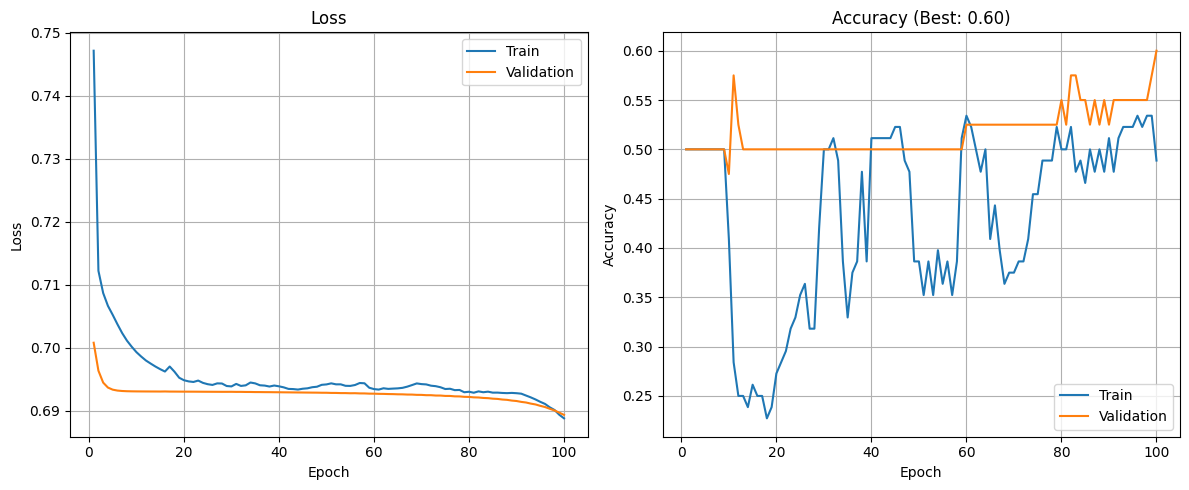

In [ ]:
results = train_and_test_your_model(base_config, 'base_model', True)

## Hyperparameter Tuning

### Increase Convolution Channels

Epoch 1, train_loss 0.86, train_accuracy: 0.4773, test_loss 0.81, test_accuracy: 0.5000, time = 2.98
Epoch 2, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.78, test_accuracy: 0.5000, time = 2.95
Epoch 3, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.77, test_accuracy: 0.5000, time = 2.93
Epoch 4, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.76, test_accuracy: 0.5000, time = 2.92
Epoch 5, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.75, test_accuracy: 0.5000, time = 2.97
Epoch 6, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.73, test_accuracy: 0.5000, time = 2.91
Epoch 7, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.5000, time = 2.95
Epoch 8, train_loss 0.83, train_accuracy: 0.5000, test_loss 0.73, test_accuracy: 0.5000, time = 2.92
Epoch 9, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.5000, time = 2.99
Epoch 10, train_loss 0.79, train_accuracy: 0.5000, test_loss 0.71, test_accuracy: 0.5000, t

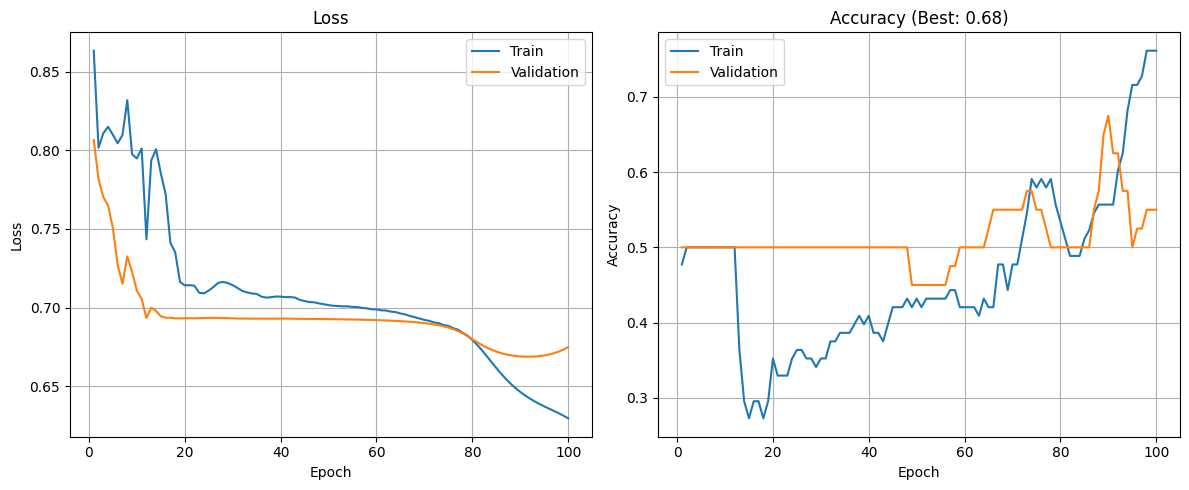

In [ ]:
increased_channel_model_config = copy.deepcopy(base_config)

increased_channel_model_config["conv_channels"]=[128,128,1]

results = train_and_test_your_model(increased_channel_model_config, '128_channel_model', False)

### Add One Convolution Layer

Epoch 1, train_loss 0.75, train_accuracy: 0.4091, test_loss 0.70, test_accuracy: 0.5000, time = 2.36
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.31
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.41
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.44
Epoch 5, train_loss 0.70, train_accuracy: 0.3523, test_loss 0.69, test_accuracy: 0.5000, time = 2.34
Epoch 6, train_loss 0.70, train_accuracy: 0.2841, test_loss 0.69, test_accuracy: 0.5000, time = 2.31
Epoch 7, train_loss 0.70, train_accuracy: 0.2727, test_loss 0.69, test_accuracy: 0.5000, time = 2.36
Epoch 8, train_loss 0.70, train_accuracy: 0.2727, test_loss 0.69, test_accuracy: 0.5000, time = 2.36
Epoch 9, train_loss 0.70, train_accuracy: 0.2955, test_loss 0.69, test_accuracy: 0.5000, time = 2.42
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, t

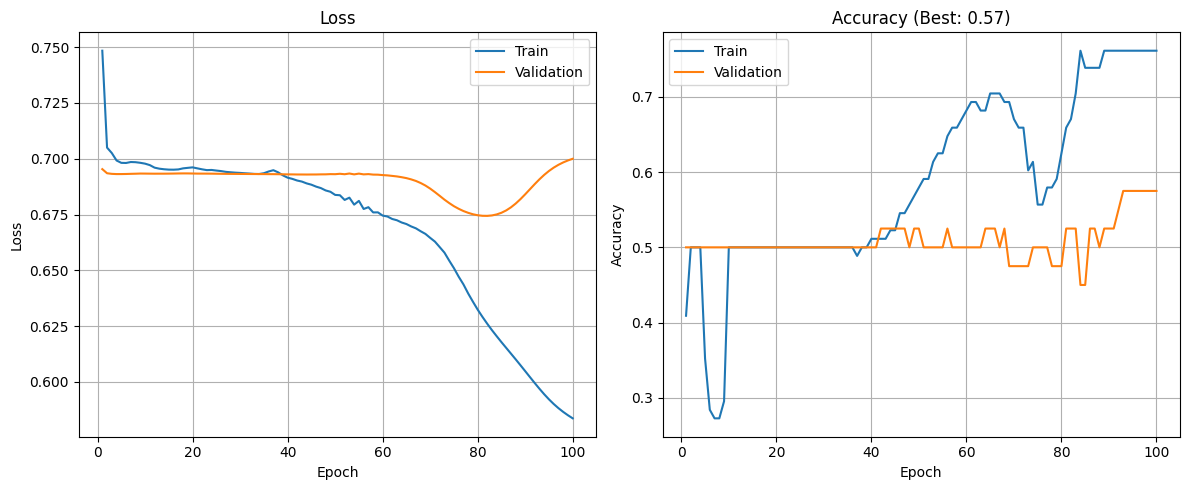

In [ ]:
increased_basic_block_config = copy.deepcopy(base_config)


increased_basic_block_config["conv_channels"]=[32, 32, 32, 1]
increased_basic_block_config["nb_basic_blocks"] = 4

results = train_and_test_your_model(increased_basic_block_config, '4_basic_blocks', False)

### Adjust Kernel Sizes (Smaller)

Epoch 1, train_loss 0.73, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.47
Epoch 2, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.34
Epoch 3, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.39
Epoch 4, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.38
Epoch 5, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.36
Epoch 6, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.45
Epoch 7, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.37
Epoch 8, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.35
Epoch 9, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.36
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, t

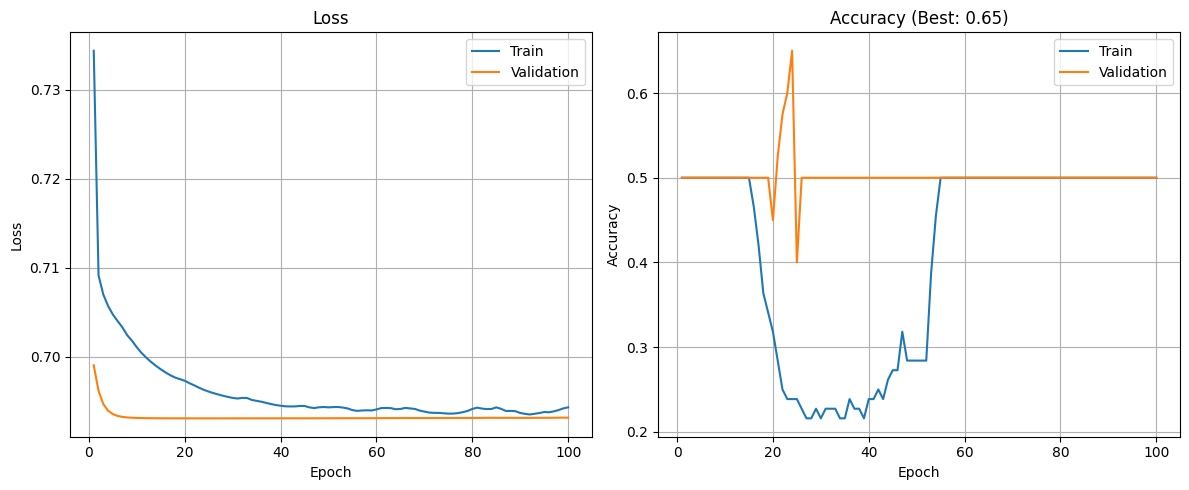

In [ ]:
reduced_kernel_size_and_stride_config = copy.deepcopy(base_config)

reduced_kernel_size_and_stride_config['kernel_size']= 7
reduced_kernel_size_and_stride_config['stride']= 3

results = train_and_test_your_model(reduced_kernel_size_and_stride_config, 'reduced_kernel_size_and_stride', False)

### Adjust Kernel Sizes (Larger)

Epoch 1, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.5000, time = 2.34
Epoch 2, train_loss 0.73, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.37
Epoch 3, train_loss 0.72, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.42
Epoch 4, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.36
Epoch 5, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.35
Epoch 6, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.31
Epoch 7, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.38
Epoch 8, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.45
Epoch 9, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.38
Epoch 10, train_loss 0.70, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.5000, t

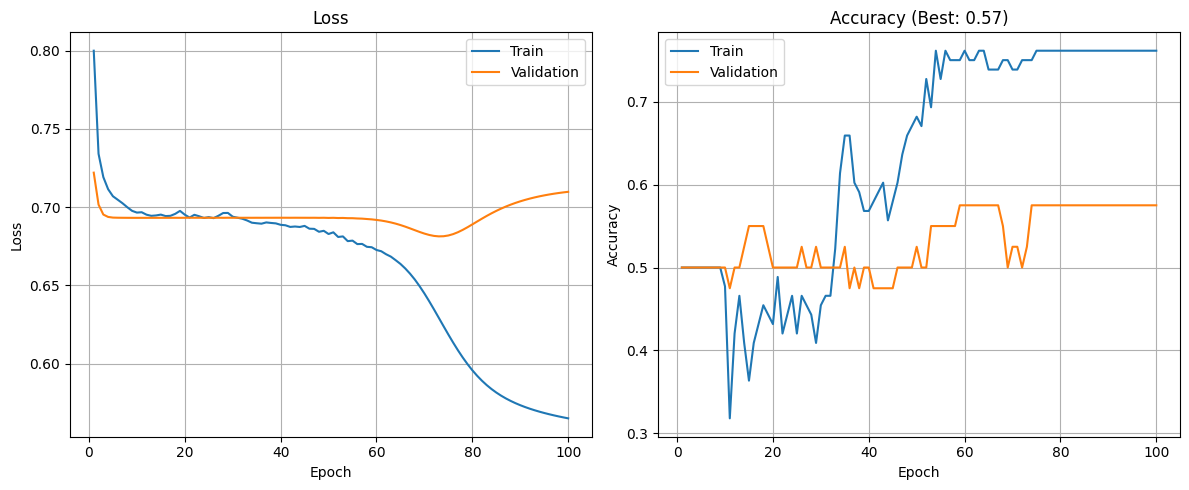

In [ ]:
increased_kernel_size_and_stride_config = copy.deepcopy(base_config)


increased_kernel_size_and_stride_config['kernel_size']= 22
increased_kernel_size_and_stride_config['stride']= 11

results =  train_and_test_your_model(increased_kernel_size_and_stride_config, 'increased_kernel_size_and_stride', False)

### Change Non-linearities

Epoch 1, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.38
Epoch 2, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.37
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.43
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.39
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.5
Epoch 6, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.49
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.44
Epoch 8, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.41
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.37
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, ti

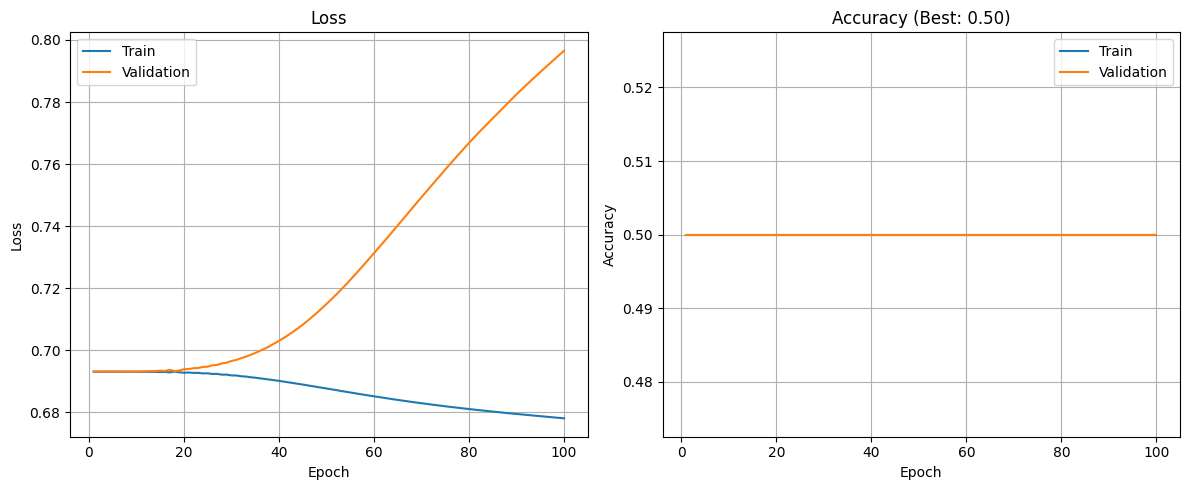

In [ ]:
relu_model_config = copy.deepcopy(base_config)

relu_model_config['non_linearity']="ReLU"

results = train_and_test_your_model(relu_model_config, 'relu_model', True)

## Optimization Practices 

### Experimentation with Adam optimizer with different learning rates


Epoch 1, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.4
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.55
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.22
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.33
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.43
Epoch 6, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.37
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.38
Epoch 8, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.22
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.22
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, ti

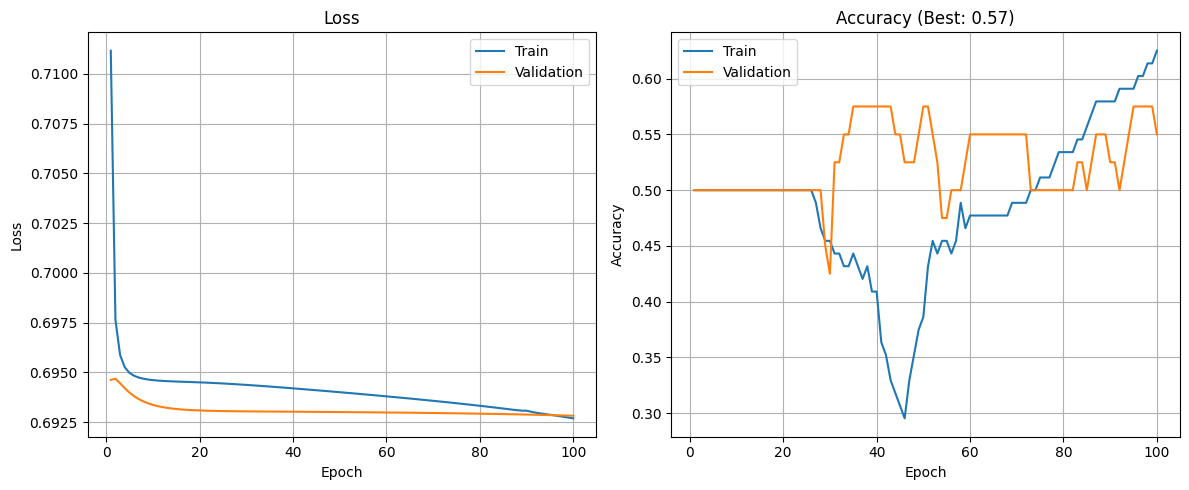

Epoch 1, train_loss 0.86, train_accuracy: 0.4091, test_loss 0.75, test_accuracy: 0.5000, time = 2.15
Epoch 2, train_loss 0.74, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.5000, time = 2.12
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.16
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.16
Epoch 5, train_loss 0.70, train_accuracy: 0.1932, test_loss 0.69, test_accuracy: 0.5000, time = 2.2
Epoch 6, train_loss 0.70, train_accuracy: 0.1364, test_loss 0.69, test_accuracy: 0.5000, time = 2.18
Epoch 7, train_loss 0.70, train_accuracy: 0.1364, test_loss 0.69, test_accuracy: 0.5000, time = 2.14
Epoch 8, train_loss 0.70, train_accuracy: 0.1364, test_loss 0.69, test_accuracy: 0.5000, time = 2.24
Epoch 9, train_loss 0.70, train_accuracy: 0.1250, test_loss 0.69, test_accuracy: 0.5000, time = 2.16
Epoch 10, train_loss 0.70, train_accuracy: 0.1250, test_loss 0.69, test_accuracy: 0.5000, ti

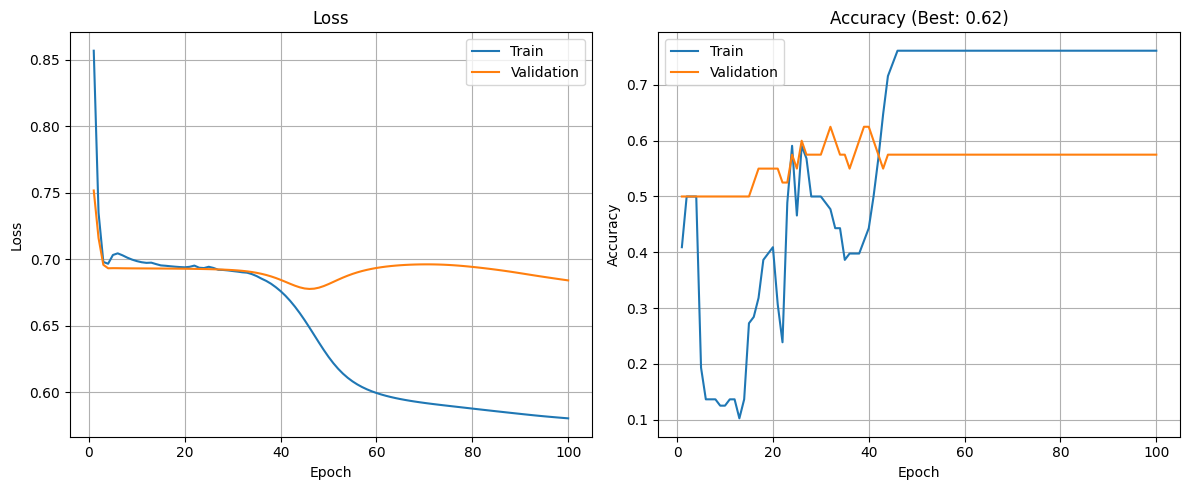

Epoch 1, train_loss 0.85, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.19
Epoch 2, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.18
Epoch 3, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.23
Epoch 4, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.15
Epoch 5, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.22
Epoch 6, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.2
Epoch 7, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.15
Epoch 8, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.14
Epoch 9, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.15
Epoch 10, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, ti

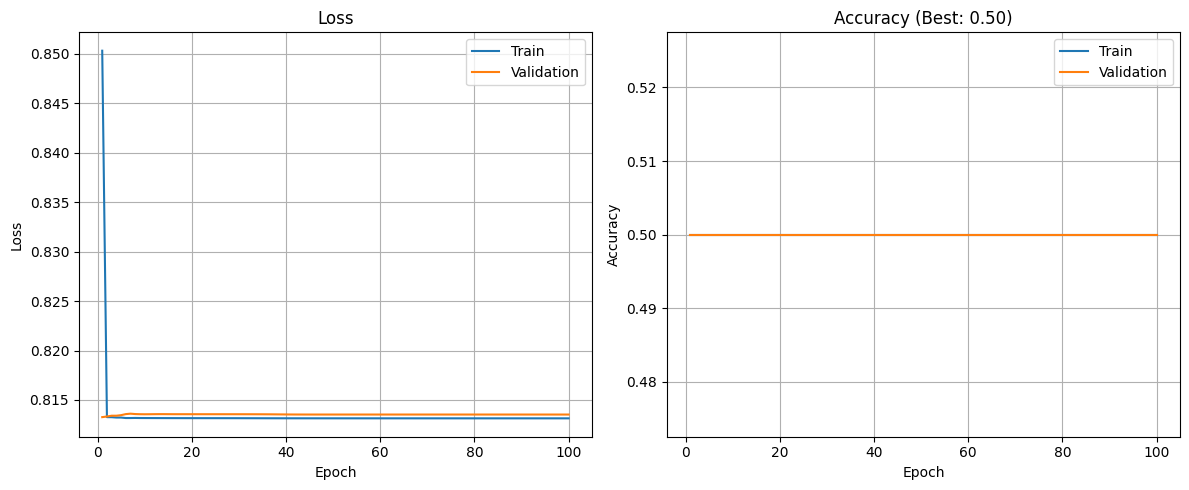

Epoch 1, train_loss 0.76, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.17
Epoch 2, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.2
Epoch 3, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.17
Epoch 4, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.12
Epoch 5, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.24
Epoch 6, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.17
Epoch 7, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.13
Epoch 8, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.22
Epoch 9, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.12
Epoch 10, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, ti

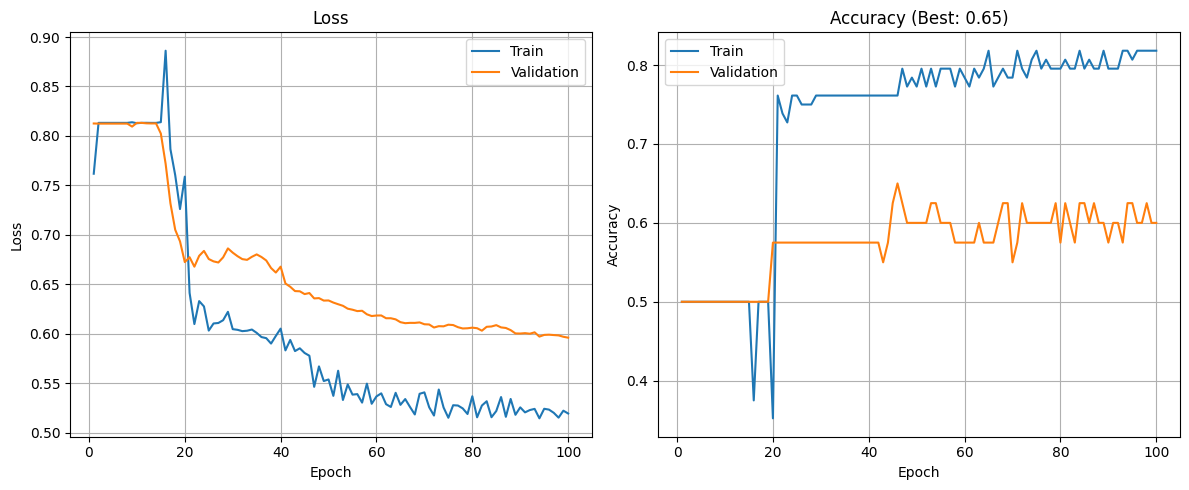

0.1
Epoch 1, train_loss 0.76, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.14
Epoch 2, train_loss 1.22, train_accuracy: 0.0682, test_loss 0.81, test_accuracy: 0.5000, time = 2.12
Epoch 3, train_loss 0.49, train_accuracy: 0.8295, test_loss 0.79, test_accuracy: 0.5000, time = 2.22
Epoch 4, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.80, test_accuracy: 0.5000, time = 2.14
Epoch 5, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.80, test_accuracy: 0.5000, time = 2.2
Epoch 6, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.80, test_accuracy: 0.5000, time = 2.12
Epoch 7, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.80, test_accuracy: 0.5000, time = 2.1
Epoch 8, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.79, test_accuracy: 0.5000, time = 2.11
Epoch 9, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.77, test_accuracy: 0.5000, time = 2.12
Epoch 10, train_loss 0.78, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.4750,

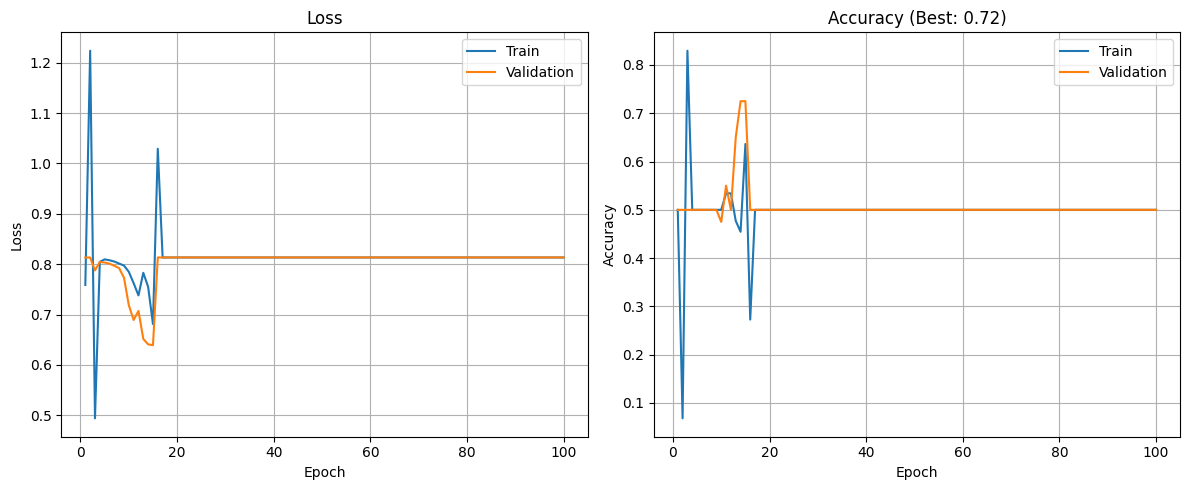

{'metrics': {'train_losses': [0.75867698951201,
   1.2236672964963047,
   0.4940361814065413,
   0.8046502362598072,
   0.8095257065512917,
   0.807806364514611,
   0.8052585775201971,
   0.8011887507005171,
   0.7972909266298468,
   0.7848208763382651,
   0.7623402422124689,
   0.7380441535602916,
   0.7828852480108087,
   0.7550872185013511,
   0.6810847276991064,
   1.0290755060586063,
   0.8132429366761987,
   0.8132580437443473,
   0.8132590326395902,
   0.8132761716842651,
   0.8132767325097864,
   0.8132711107080633,
   0.8132660280574452,
   0.8132645487785339,
   0.8132641857320612,
   0.8132640340111472,
   0.8132639689878984,
   0.8132639256390658,
   0.8132639039646495,
   0.8132638822902333,
   0.813263860615817,
   0.8132638389414008,
   0.8132638389414008,
   0.8132638199762865,
   0.8132638226855885,
   0.8132638010111722,
   0.8132638010111722,
   0.8132638010111722,
   0.813263779336756,
   0.813263779336756,
   0.813263779336756,
   0.813263779336756,
   0.8132637576

In [ ]:
optimizer_lr_config = copy.deepcopy(base_config)

optimizer_lr_config['batch_size'] = 8
learning_rates = [0.0001, 0.001, 0.01, 0.1]
best_val = -1.0
best_learning_rate = None

for lr in learning_rates:
  optimizer_lr_config['learning_rate'] = lr
  temp_results = train_and_test_your_model(optimizer_lr_config, f'lr_{lr}', save_model=False)
  max_val_acc = max(temp_results['metrics']['validation_accuracy'])
  if max_val_acc > best_val:
        best_val = max_val_acc
        best_learning_rate = lr

optimizer_lr_config['learning_rate'] = best_learning_rate

print(best_learning_rate)
train_and_test_your_model(optimizer_lr_config, 'lr_model', save_model=True)

### Experimentation with Adam optimizer with different learning rates and shuffling data in each batch

Epoch 1, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.25
Epoch 2, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.11
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.11
Epoch 4, train_loss 0.69, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.33
Epoch 5, train_loss 0.69, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.5000, time = 2.19
Epoch 6, train_loss 0.69, train_accuracy: 0.4318, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 8, train_loss 0.69, train_accuracy: 0.5341, test_loss 0.69, test_accuracy: 0.5750, time = 2.17
Epoch 9, train_loss 0.69, train_accuracy: 0.5795, test_loss 0.69, test_accuracy: 0.5000, time = 2.13
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, ti

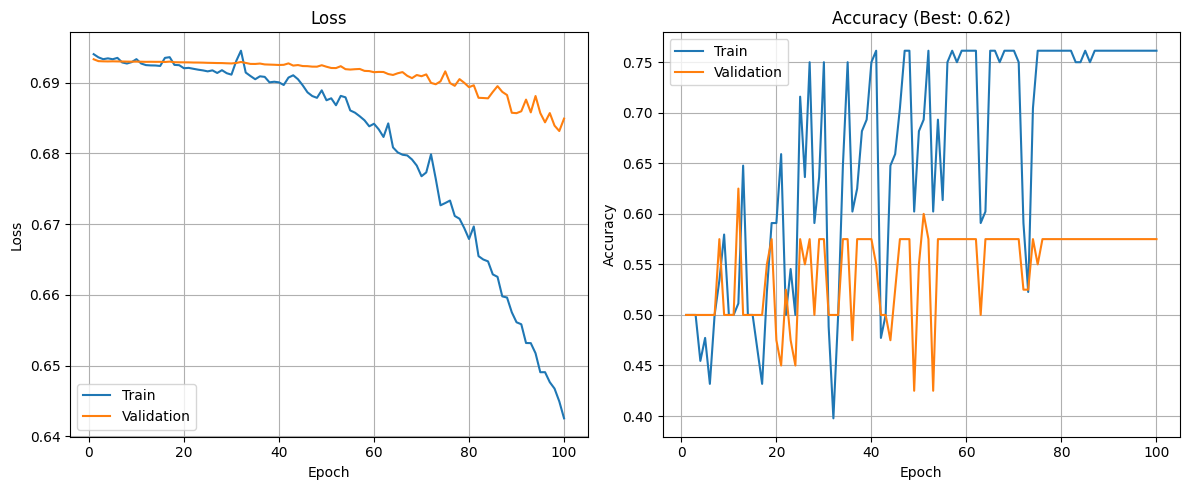

Epoch 1, train_loss 0.70, train_accuracy: 0.4432, test_loss 0.69, test_accuracy: 0.5000, time = 2.13
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.14
Epoch 3, train_loss 0.70, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.08
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 5, train_loss 0.70, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.16
Epoch 6, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.22
Epoch 7, train_loss 0.69, train_accuracy: 0.5227, test_loss 0.69, test_accuracy: 0.5250, time = 2.13
Epoch 8, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.12
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5750, time = 2.12
Epoch 10, train_loss 0.69, train_accuracy: 0.5114, test_loss 0.69, test_accuracy: 0.5000, ti

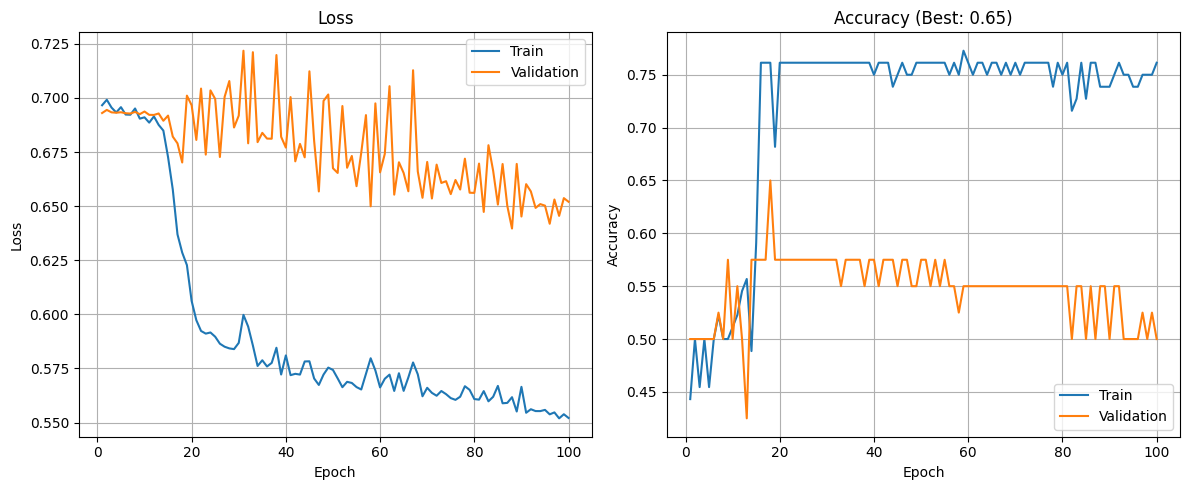

Epoch 1, train_loss 0.78, train_accuracy: 0.5227, test_loss 0.81, test_accuracy: 0.5000, time = 2.18
Epoch 2, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.13
Epoch 3, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.12
Epoch 4, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.11
Epoch 5, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.13
Epoch 6, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.15
Epoch 7, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.17
Epoch 8, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.2
Epoch 9, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.14
Epoch 10, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, ti

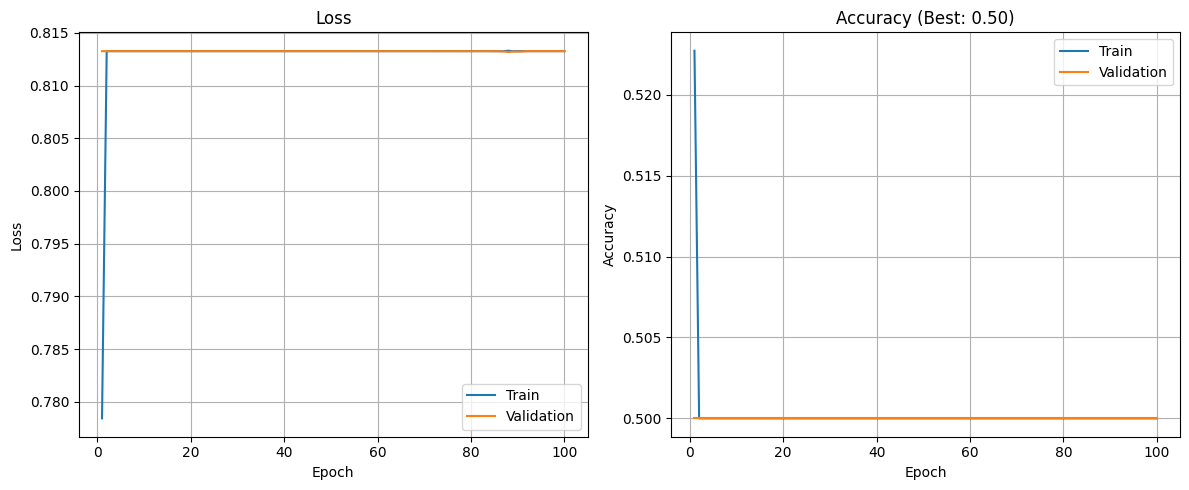

Epoch 1, train_loss 0.79, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.16
Epoch 2, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.17
Epoch 3, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.12
Epoch 4, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.11
Epoch 5, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.75, test_accuracy: 0.5000, time = 2.14
Epoch 6, train_loss 0.84, train_accuracy: 0.4432, test_loss 0.82, test_accuracy: 0.5000, time = 2.12
Epoch 7, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.82, test_accuracy: 0.5000, time = 2.08
Epoch 8, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.82, test_accuracy: 0.5000, time = 2.21
Epoch 9, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.82, test_accuracy: 0.5000, time = 2.11
Epoch 10, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.82, test_accuracy: 0.5000, t

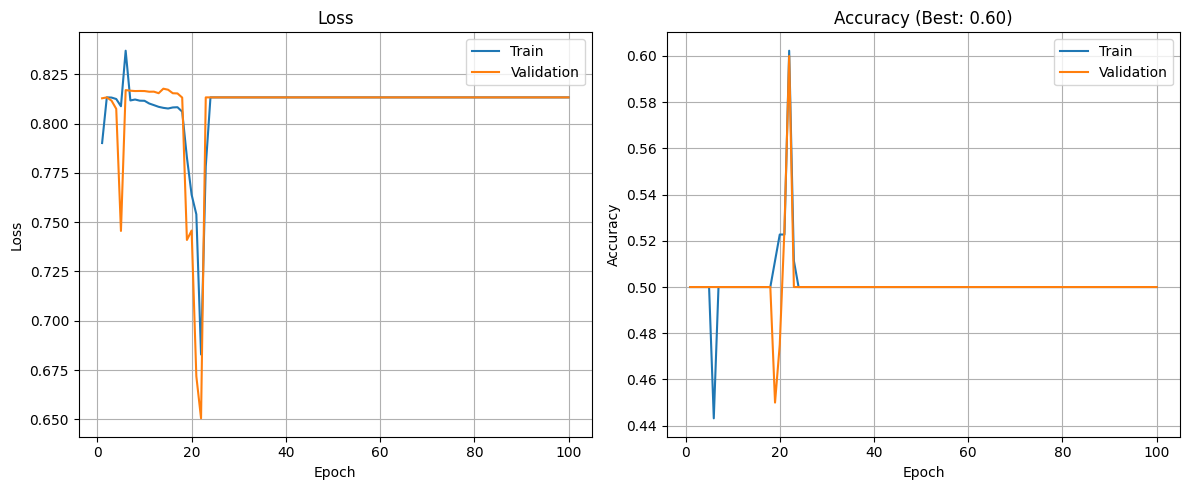

0.001
Epoch 1, train_loss 0.71, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 2, train_loss 0.70, train_accuracy: 0.4318, test_loss 0.69, test_accuracy: 0.5000, time = 2.12
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.13
Epoch 4, train_loss 0.69, train_accuracy: 0.5227, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 6, train_loss 0.69, train_accuracy: 0.4886, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.13
Epoch 8, train_loss 0.69, train_accuracy: 0.5682, test_loss 0.69, test_accuracy: 0.4250, time = 2.12
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 10, train_loss 0.69, train_accuracy: 0.5909, test_loss 0.69, test_accuracy: 0.500

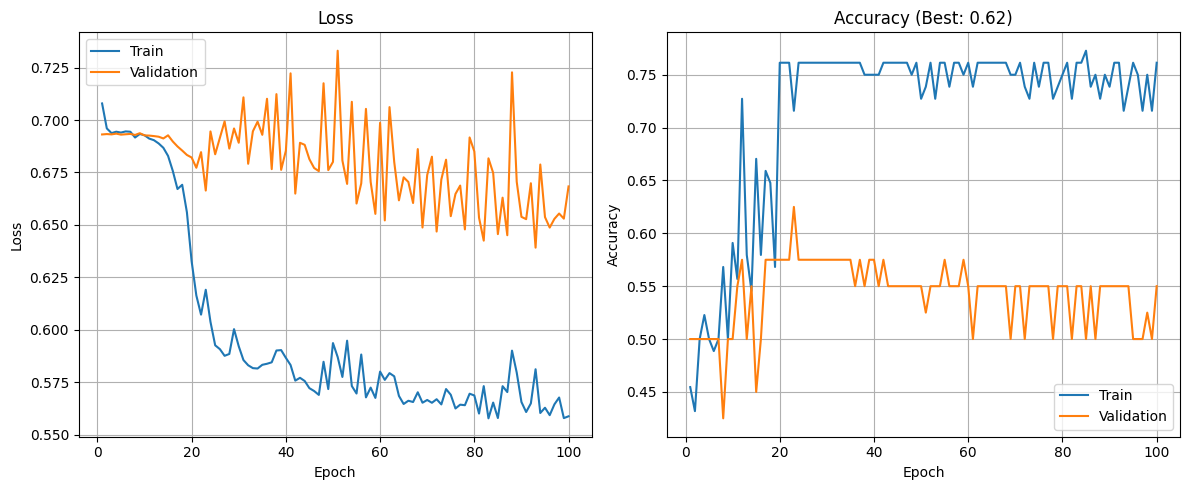

In [ ]:
shuffle_model_config = copy.deepcopy(base_config)

shuffle_model_config['shuffle']= True
shuffle_model_config['batch_size'] = 8

learning_rates = [0.0001, 0.001, 0.01, 0.1]
best_val = -1.0
best_learning_rate = None

for lr in learning_rates:
  shuffle_model_config['learning_rate'] = lr
  temp_results = train_and_test_your_model(shuffle_model_config, f'lr_{lr}', save_model=False)
  max_val_acc = max(temp_results['metrics']['validation_accuracy'])
  if max_val_acc > best_val:
        best_val = max_val_acc
        best_learning_rate = lr

shuffle_model_config['learning_rate'] = best_learning_rate

print(best_learning_rate)

results = train_and_test_your_model(shuffle_model_config, 'shuffle_model', True)

### Experimentation with Adam optimizer and different batch sizes

Epoch 1, train_loss 0.88, train_accuracy: 0.4545, test_loss 0.81, test_accuracy: 0.5000, time = 2.2
Epoch 2, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.2
Epoch 3, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.19
Epoch 4, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.19
Epoch 5, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.23
Epoch 6, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.19
Epoch 7, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.14
Epoch 8, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.80, test_accuracy: 0.5000, time = 2.19
Epoch 9, train_loss 0.82, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.19
Epoch 10, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.80, test_accuracy: 0.5000, tim

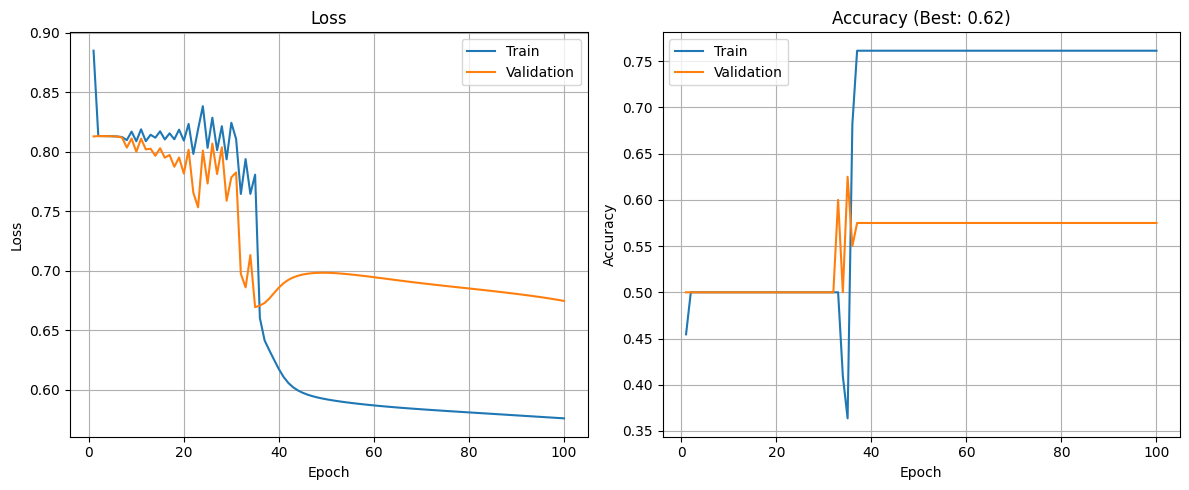

Epoch 1, train_loss 0.85, train_accuracy: 0.5000, test_loss 0.76, test_accuracy: 0.5000, time = 2.18
Epoch 2, train_loss 0.75, train_accuracy: 0.5000, test_loss 0.73, test_accuracy: 0.5000, time = 2.15
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.17
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.2
Epoch 5, train_loss 0.70, train_accuracy: 0.1364, test_loss 0.69, test_accuracy: 0.5000, time = 2.14
Epoch 6, train_loss 0.71, train_accuracy: 0.0455, test_loss 0.69, test_accuracy: 0.5000, time = 2.11
Epoch 7, train_loss 0.70, train_accuracy: 0.0455, test_loss 0.69, test_accuracy: 0.5000, time = 2.13
Epoch 8, train_loss 0.70, train_accuracy: 0.0455, test_loss 0.69, test_accuracy: 0.5000, time = 2.14
Epoch 9, train_loss 0.70, train_accuracy: 0.1136, test_loss 0.69, test_accuracy: 0.5250, time = 2.21
Epoch 10, train_loss 0.70, train_accuracy: 0.2273, test_loss 0.69, test_accuracy: 0.4500, ti

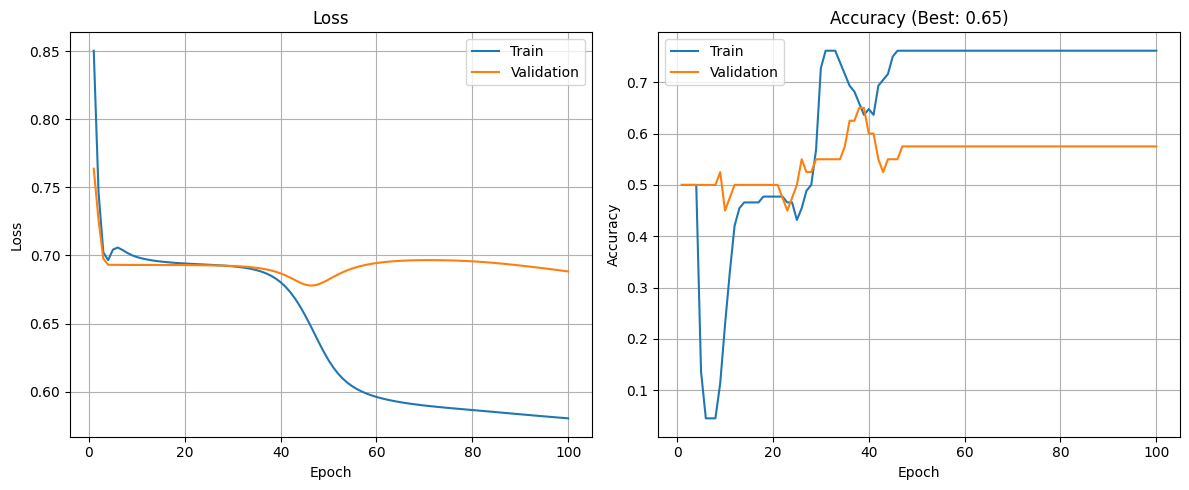

Epoch 1, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.76, test_accuracy: 0.5000, time = 2.18
Epoch 2, train_loss 0.72, train_accuracy: 0.5000, test_loss 0.73, test_accuracy: 0.5000, time = 2.18
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.21
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.16
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.09
Epoch 6, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 2.09
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 2.13
Epoch 8, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 2.14
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 2.24
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, t

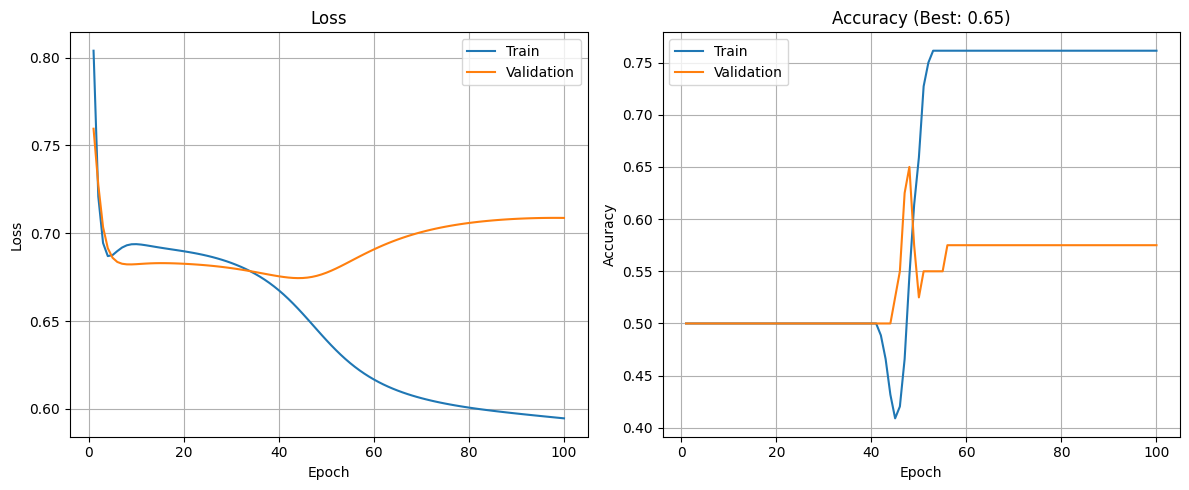

Epoch 1, train_loss 0.73, train_accuracy: 0.1364, test_loss 0.71, test_accuracy: 0.5000, time = 2.14
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.71, test_accuracy: 0.5000, time = 2.15
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.71, test_accuracy: 0.5000, time = 2.17
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.25
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.24
Epoch 6, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.14
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 2.12
Epoch 8, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 2.1
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 2.16
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.67, test_accuracy: 0.5000, ti

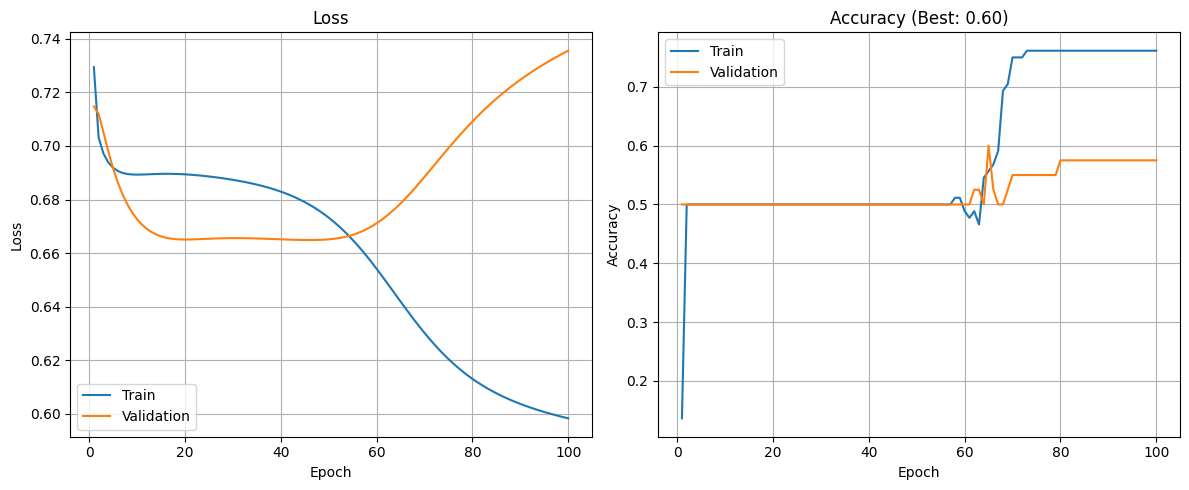

8
Epoch 1, train_loss 0.84, train_accuracy: 0.5000, test_loss 0.75, test_accuracy: 0.5000, time = 2.11
Epoch 2, train_loss 0.74, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.5000, time = 2.15
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.25
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 5, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.13
Epoch 6, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 7, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.12
Epoch 8, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 9, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.18
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, 

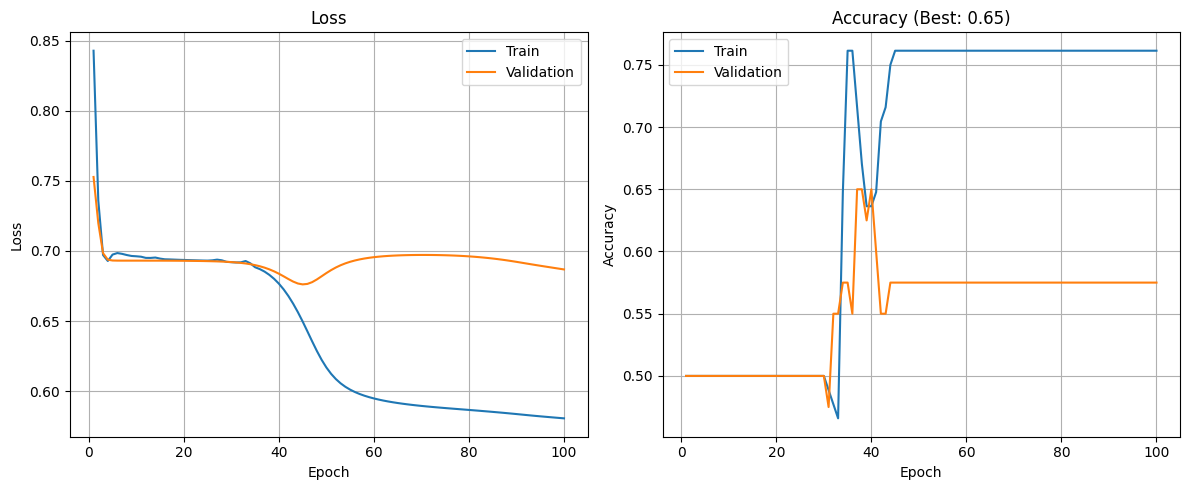

In [ ]:
shuffle_model_config = copy.deepcopy(base_config)

shuffle_model_config['shuffle']= False
shuffle_model_config['learning_rate'] = 0.001

bs = [4, 8, 16, 32]
best_val = -1.0
best_bs = None

for b in bs:
  shuffle_model_config['batch_size'] = b
  temp_results = train_and_test_your_model(shuffle_model_config, f'lr_{b}', save_model=False)
  max_val_acc = max(temp_results['metrics']['validation_accuracy'])
  if max_val_acc > best_val:
        best_val = max_val_acc
        best_bs = b

shuffle_model_config['batch_size'] = best_bs

print(best_bs)

results = train_and_test_your_model(shuffle_model_config, 'bs_model', True)

### Experimentation with SGD optimizer with different learning rates and shuffling data in each batch

Epoch 1, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.17
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.14
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.11
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.09
Epoch 5, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.2
Epoch 6, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.14
Epoch 7, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.14
Epoch 8, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.12
Epoch 9, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.11
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, ti

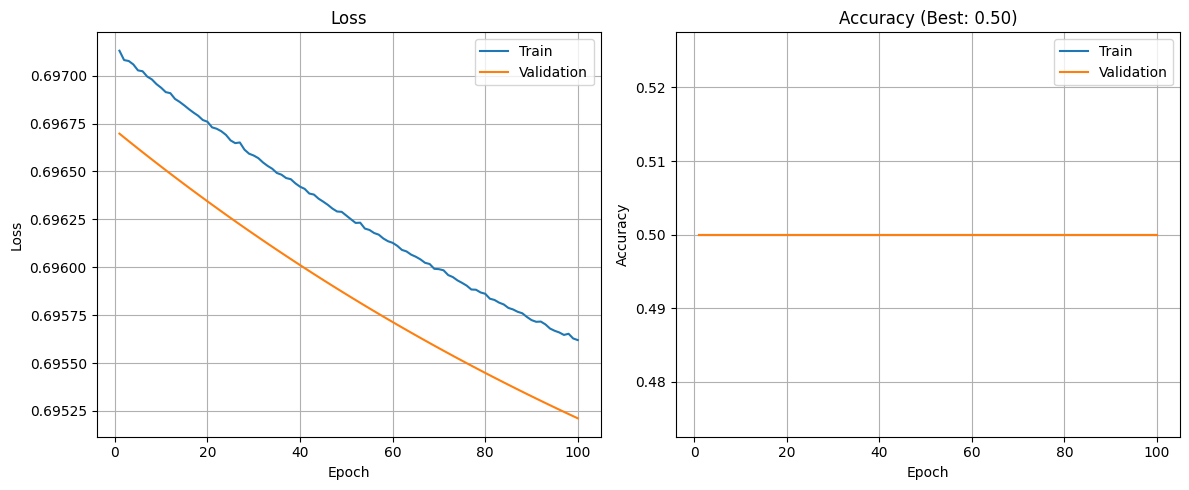

Epoch 1, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.16
Epoch 2, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.13
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.12
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.11
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.14
Epoch 6, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.23
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.13
Epoch 8, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.09
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, t

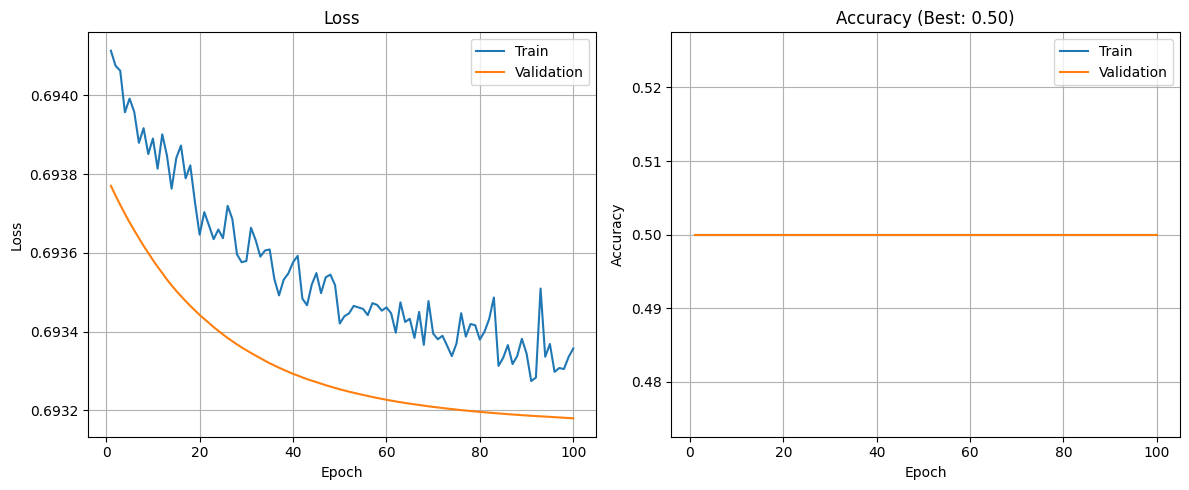

Epoch 1, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.21
Epoch 2, train_loss 0.69, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 3, train_loss 0.70, train_accuracy: 0.4318, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 4, train_loss 0.69, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 5, train_loss 0.69, train_accuracy: 0.4318, test_loss 0.69, test_accuracy: 0.5000, time = 2.08
Epoch 6, train_loss 0.69, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.09
Epoch 7, train_loss 0.69, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.19
Epoch 8, train_loss 0.69, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.12
Epoch 9, train_loss 0.70, train_accuracy: 0.4318, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 10, train_loss 0.69, train_accuracy: 0.4318, test_loss 0.69, test_accuracy: 0.5000, time

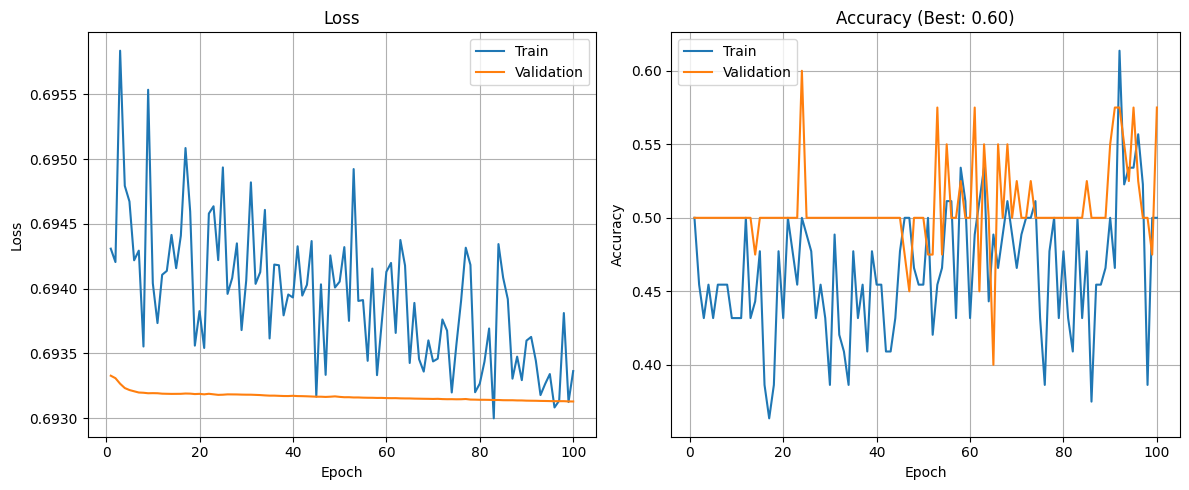

Epoch 1, train_loss 0.71, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 2, train_loss 0.70, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.5000, time = 2.16
Epoch 3, train_loss 0.70, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.17
Epoch 4, train_loss 0.70, train_accuracy: 0.4091, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 5, train_loss 0.70, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 6, train_loss 0.70, train_accuracy: 0.4886, test_loss 0.69, test_accuracy: 0.5000, time = 2.11
Epoch 7, train_loss 0.70, train_accuracy: 0.3182, test_loss 0.69, test_accuracy: 0.5000, time = 2.11
Epoch 8, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.2
Epoch 9, train_loss 0.69, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.5000, time = 2.11
Epoch 10, train_loss 0.70, train_accuracy: 0.4318, test_loss 0.69, test_accuracy: 0.5000, time

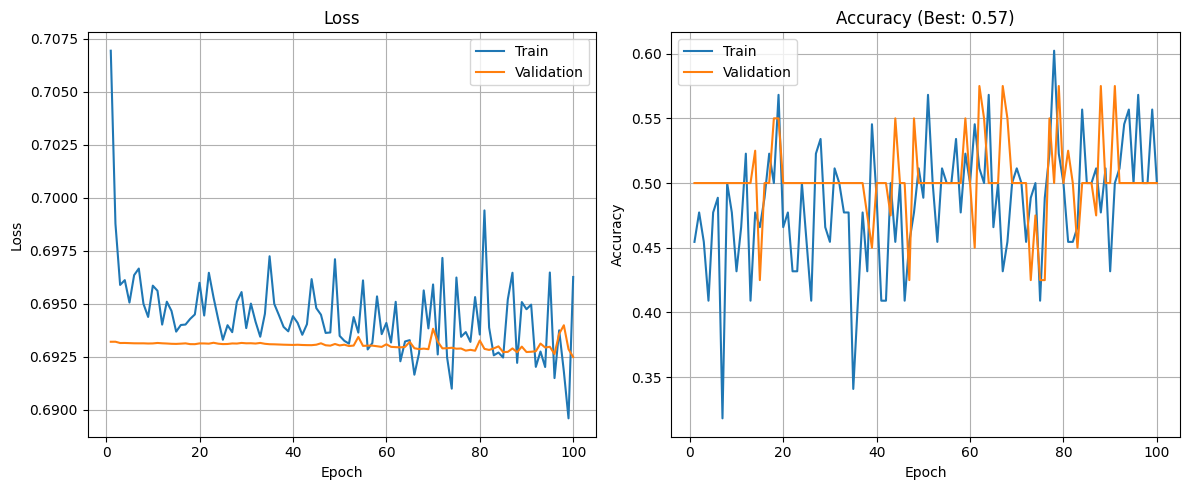

0.01
Epoch 1, train_loss 0.69, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.5000, time = 2.12
Epoch 2, train_loss 0.69, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.12
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 4, train_loss 0.69, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.5000, time = 2.22
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.16
Epoch 6, train_loss 0.69, train_accuracy: 0.3750, test_loss 0.69, test_accuracy: 0.5000, time = 2.22
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.12
Epoch 8, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.14
Epoch 9, train_loss 0.69, train_accuracy: 0.4091, test_loss 0.69, test_accuracy: 0.5000, time = 2.15
Epoch 10, train_loss 0.69, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.50

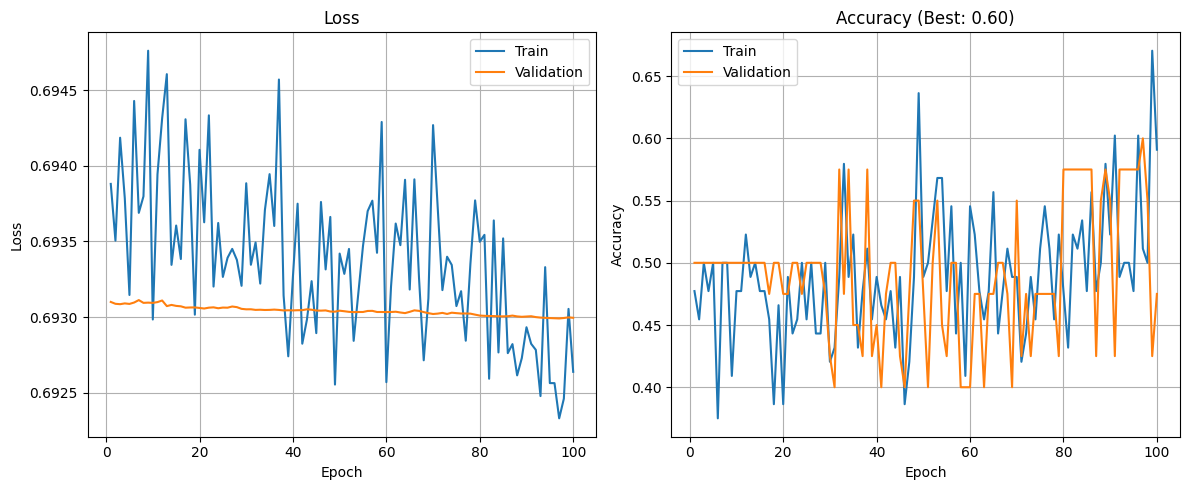

In [ ]:
sgd_model_config = copy.deepcopy(shuffle_model_config)

sgd_model_config['shuffle']= True
sgd_model_config['optimizer_type']="SGD"

learning_rates = [0.0001, 0.001, 0.01, 0.1]
best_val = -1.0
best_learning_rate = None

for lr in learning_rates:
  sgd_model_config['learning_rate'] = lr
  temp_results = train_and_test_your_model(sgd_model_config, f'lr_{lr}', save_model=False)
  max_val_acc = max(temp_results['metrics']['validation_accuracy'])
  if max_val_acc > best_val:
        best_val = max_val_acc
        best_learning_rate = lr

sgd_model_config['learning_rate'] = best_learning_rate

print(best_learning_rate)

results = train_and_test_your_model(sgd_model_config, 'SGD_model', True)

### Task 3.5: Experimentation with SGD optimizer and normalization layers

**useful link**: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

Epoch 1, train_loss 0.69, train_accuracy: 0.6477, test_loss 0.70, test_accuracy: 0.5000, time = 2.13
Epoch 2, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.1
Epoch 3, train_loss 0.71, train_accuracy: 0.4091, test_loss 0.69, test_accuracy: 0.5000, time = 2.17
Epoch 4, train_loss 0.71, train_accuracy: 0.2500, test_loss 0.68, test_accuracy: 0.5000, time = 2.1
Epoch 5, train_loss 0.71, train_accuracy: 0.4091, test_loss 0.68, test_accuracy: 0.5000, time = 2.14
Epoch 6, train_loss 0.71, train_accuracy: 0.4091, test_loss 0.68, test_accuracy: 0.5000, time = 2.15
Epoch 7, train_loss 0.71, train_accuracy: 0.3182, test_loss 0.68, test_accuracy: 0.5000, time = 2.18
Epoch 8, train_loss 0.71, train_accuracy: 0.4318, test_loss 0.68, test_accuracy: 0.5000, time = 2.12
Epoch 9, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 2.1
Epoch 10, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time

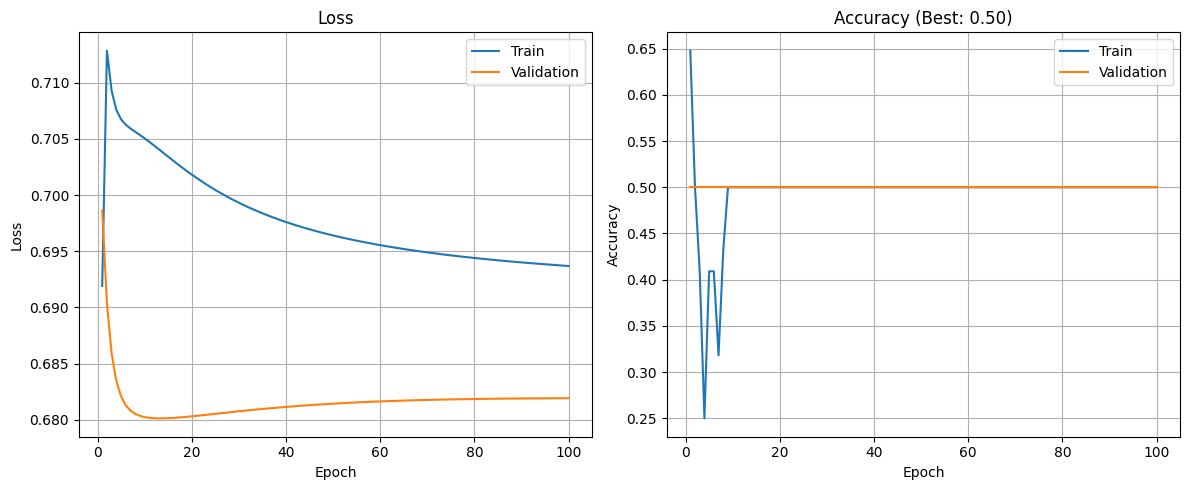

In [ ]:
normalization_model_config = copy.deepcopy(base_config)


normalization_model_config['shuffle']= False
normalization_model_config["learning_rate"]=0.01
normalization_model_config["batch_size"] = 16
normalization_model_config["optimizer_type"] = "SGD"
normalization_model_config["use_batchnorm"]=True

results = train_and_test_your_model(normalization_model_config, 'normalization_model', False)

## Regularization Practices 

### Model Architecture

Epoch 1, train_loss 0.85, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 3.05
Epoch 2, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 3.0
Epoch 3, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 3.01
Epoch 4, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 3.02
Epoch 5, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 3.04
Epoch 6, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.96
Epoch 7, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 3.02
Epoch 8, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 3.04
Epoch 9, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 3.06
Epoch 10, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, ti

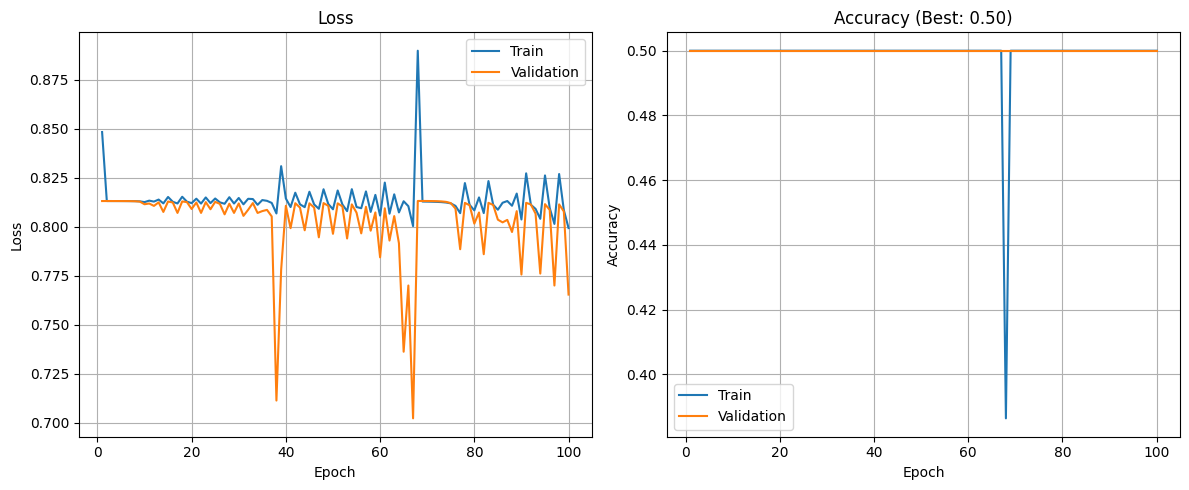

In [ ]:
channel_128_config = copy.deepcopy(base_config)

channel_128_config["conv_channels"]=[128, 128, 128, 1]
channel_128_config["nb_basic_blocks"] = 4

results = train_and_test_your_model(channel_128_config, 'channel_128', False)

### Experimentation with normalization layers


Epoch 1, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.42
Epoch 2, train_loss 0.75, train_accuracy: 0.4773, test_loss 0.68, test_accuracy: 0.5750, time = 2.4
Epoch 3, train_loss 0.64, train_accuracy: 0.7614, test_loss 0.67, test_accuracy: 0.5750, time = 2.32
Epoch 4, train_loss 0.63, train_accuracy: 0.7614, test_loss 0.67, test_accuracy: 0.5750, time = 2.32
Epoch 5, train_loss 0.62, train_accuracy: 0.7614, test_loss 0.68, test_accuracy: 0.5750, time = 2.28
Epoch 6, train_loss 0.62, train_accuracy: 0.7614, test_loss 0.68, test_accuracy: 0.5750, time = 2.44
Epoch 7, train_loss 0.61, train_accuracy: 0.7614, test_loss 0.68, test_accuracy: 0.5750, time = 2.41
Epoch 8, train_loss 0.60, train_accuracy: 0.7614, test_loss 0.69, test_accuracy: 0.5750, time = 2.32
Epoch 9, train_loss 0.60, train_accuracy: 0.7614, test_loss 0.69, test_accuracy: 0.5750, time = 2.32
Epoch 10, train_loss 0.60, train_accuracy: 0.7614, test_loss 0.69, test_accuracy: 0.5750, ti

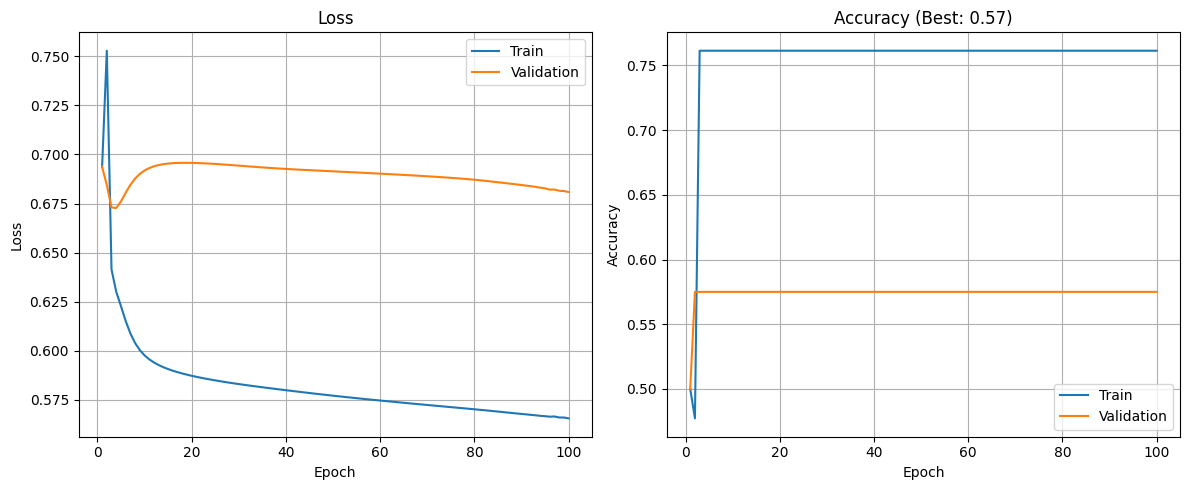

In [ ]:
normalized_config = copy.deepcopy(base_config)

normalized_config['use_batchnorm']= True

results = train_and_test_your_model(normalized_config, 'normalized_model', True)

### Experimentation with dropout layers


Epoch 1, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5250, time = 2.36
Epoch 2, train_loss 0.74, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.4250, time = 2.28
Epoch 3, train_loss 0.67, train_accuracy: 0.6250, test_loss 0.69, test_accuracy: 0.5750, time = 2.34
Epoch 4, train_loss 0.66, train_accuracy: 0.7614, test_loss 0.68, test_accuracy: 0.5750, time = 2.36
Epoch 5, train_loss 0.65, train_accuracy: 0.7614, test_loss 0.68, test_accuracy: 0.5500, time = 2.36
Epoch 6, train_loss 0.64, train_accuracy: 0.7614, test_loss 0.67, test_accuracy: 0.5500, time = 2.3
Epoch 7, train_loss 0.64, train_accuracy: 0.7614, test_loss 0.67, test_accuracy: 0.5750, time = 2.29
Epoch 8, train_loss 0.63, train_accuracy: 0.7614, test_loss 0.67, test_accuracy: 0.5750, time = 2.3
Epoch 9, train_loss 0.62, train_accuracy: 0.7614, test_loss 0.68, test_accuracy: 0.5750, time = 2.38
Epoch 10, train_loss 0.62, train_accuracy: 0.7614, test_loss 0.68, test_accuracy: 0.5750, tim

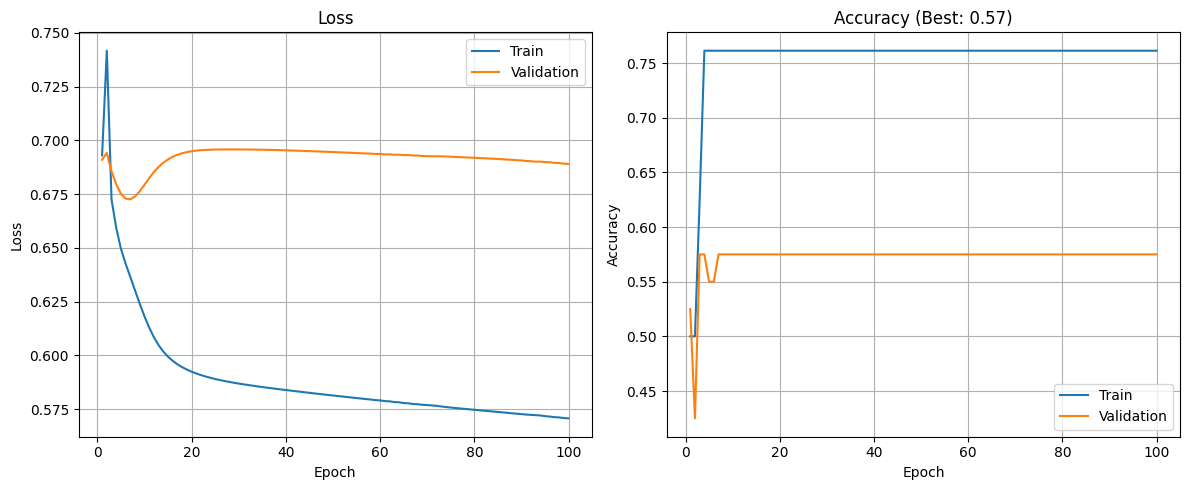

In [ ]:
dropout_config = copy.deepcopy(base_config)

dropout_config['use_batchnorm']= True
dropout_config["use_dropout"]=True

results = train_and_test_your_model(dropout_config, 'dropout_model', False)

### Experimentation with efficient model architecture through pooling layers


Epoch 1, train_loss 0.70, train_accuracy: 0.4091, test_loss 0.69, test_accuracy: 0.5000, time = 114.76
Epoch 2, train_loss 0.72, train_accuracy: 0.4205, test_loss 0.70, test_accuracy: 0.5000, time = 2.81
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.8
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.71
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.4750, time = 2.63
Epoch 6, train_loss 0.69, train_accuracy: 0.4886, test_loss 0.69, test_accuracy: 0.4500, time = 2.66
Epoch 7, train_loss 0.69, train_accuracy: 0.4659, test_loss 0.69, test_accuracy: 0.4500, time = 2.73
Epoch 8, train_loss 0.69, train_accuracy: 0.4432, test_loss 0.69, test_accuracy: 0.4500, time = 2.72
Epoch 9, train_loss 0.68, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.4750, time = 2.67
Epoch 10, train_loss 0.68, train_accuracy: 0.5227, test_loss 0.68, test_accuracy: 0.4750, 

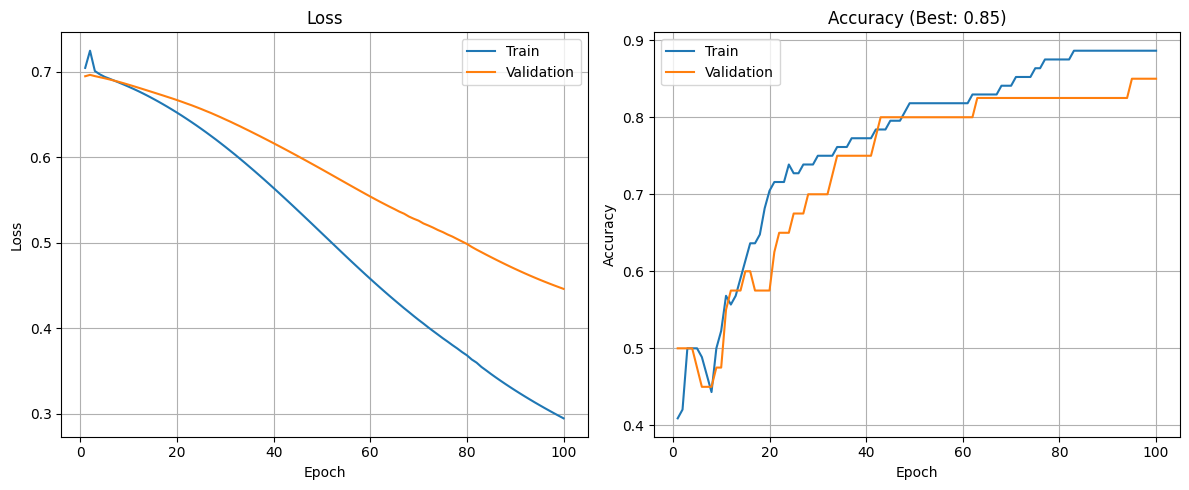

In [ ]:
pooling_config = copy.deepcopy(base_config)

pooling_config["kernel_size"]=10
pooling_config["stride"]=2
pooling_config["non_linearity"]="ReLU"
pooling_config['use_batchnorm']= True,
pooling_config['use_dropout']=True
pooling_config["apply_pooling"]=True
pooling_config['conv_channels']=[8,16,32]

results = train_and_test_your_model(pooling_config, 'pooled_model', True)